## Kaggle dataset

In [137]:
# load package
import nltk
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
#display(data)

In [2]:
df_train_var = pd.read_csv("../data/training_variants.txt")
df_test_var = pd.read_csv("../data/test_variants")
print(df_train_var.shape)
df_train_var.head()

(3321, 4)


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [3]:
df_test_var.head()

,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


### Check distribution of classes

In [4]:
# in training set
def class_ratio(df):
    df_class_ratio = df.groupby('Class').Gene.count()/len(df_train_var)
    df_class_ratio.sort_values(ascending=False).plot(kind='bar')
        
def gene_var_count(df):
    return df.groupby("Gene").count()
    
def gene_class_ratio(df):
    class_ratio = df.groupby(["Gene","Class"]).\
    Variation.count().unstack().fillna(0).\
    apply(lambda x: round((x/np.sum(x)),2),axis=1)
    return class_ratio

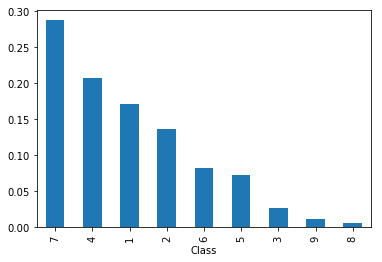

In [5]:
class_ratio(df_train_var)

In [6]:
gene_var_count(df_train_var).head()

,ID,Variation,Class
Gene,,,
ABL1,26,26,26
ACVR1,3,3,3
AGO2,5,5,5
AKT1,28,28,28
AKT2,11,11,11


In [7]:
gene_class_ratio(df_train_var).head()

Class,1,2,3,4,5,6,7,8,9
Gene,,,,,,,,,
ABL1,0.0,0.92,0.00,0.0,0.00,0.0,0.08,0.00,0.00
ACVR1,0.0,0.33,0.00,0.0,0.00,0.0,0.67,0.00,0.00
AGO2,0.8,0.20,0.00,0.0,0.00,0.0,0.00,0.00,0.00
AKT1,0.0,0.11,0.11,0.0,0.11,0.0,0.61,0.07,0.00
AKT2,0.0,0.09,0.00,0.0,0.00,0.0,0.73,0.00,0.18


## Load data and join table

In [8]:
df_train_txt = pd.read_csv('/Users/wanggene/Downloads/MoreData/kaggle_P04/training_text.txt', sep='\|\|', header=None, skiprows=1,names=["ID","Text"])
df_test_txt = pd.read_csv('/Users/wanggene/Downloads/MoreData/kaggle_P04/test_text.txt', sep='\|\|', header=None, skiprows=1,names=["ID","Text"])

print("train", df_train_txt.shape)
print("test", df_test_txt.shape)

/Users/wanggene/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/Users/wanggene/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


train (3321, 2)
test (5668, 2)


In [9]:
# train dataset
df_train = pd.merge(df_train_var, df_train_txt, how='left', on='ID')
# test dataset
df_test = pd.merge(df_test_var, df_test_txt, how='left', on='ID')
#df_test.head()
print(df_train.shape)
print(df_test.shape)
df_train.head()

(3321, 5)
(5668, 4)


,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


### Original table

In [2]:
df_train.head()
df_train2 = df_train.copy()

### Adding new features

In [148]:
# counts
def gene_count(df):
    x, y = df.Gene, df.Text
    return len(re.findall(x,y))

def var_count(df):
    x, y = df.Variation, df.Text
    return len(re.findall(x,y)) 

def gene_count_mu(df):
    x, y = df.Gene, df.Text
    x = x + " mutation"
    return len(re.findall(x, y))

# new text bag
def gene_context(df): # extract context starts with Gene
    #re_word = ".{5}" + "(?i)" + word + " .{100}"   # extract by length
    re_word = ".{5}" + "(?i)" + df.Gene + ".*?[\.;!?] " # extract by the 
    context = re.findall(re_word, df.Text,  re.MULTILINE | re.DOTALL )
    return '|'.join(context)

def var_context(df): # extract context starts with Variations
    re_word = ".{5}" + "(?i)" + df.Variation + ".*?[\.;!?] " # extract by the 
    context = re.findall(re_word, df.Text,  re.MULTILINE | re.DOTALL )
    return '|'.join(context)

def word_context(word, df): # input any word interested to extract context
    re_word = ".{50}" + "(?i)" + word + ".*?[\.;!?] " # extract by the 
    context = re.findall(re_word, df.Text,  re.MULTILINE | re.DOTALL )
    return '|'.join(context)

In [265]:
# Test
n = 4
word = "tumor"
df_text1 = df_train.loc[n]
print(df_text1)
word_context(word, df_text1)[:1000]

ID                                                           4
Gene                                                       CBL
Variation                                                L399V
Class                                                        4
Text         Oncogenic mutations in the monomeric Casitas B...
Name: 4, dtype: object


'neage lymphoma (Cbl) gene have been found in many tumors, but their significance remains largely unknown. | mutations which can potentially be implicated in tumorigenensis (1). |tations can provide selective growth advantage to tumor cells (driver mutations), the large majority of them are considered to be neutral (passenger mutations). |) were found in human myeloid neoplasms and other tumors (5) but the significance of these mutations and their impacts on CBL function were studied only for very few mutants (7). |h might not be energetically optimal (36, 42). In tumorigenesis, protein stability or binding may be reduced (or in some cases increased) due to cancer mutations. | confer a fitness advantage for the population of tumor cells (43, 44). | the stability-activity tradeoff in oncogenes and tumor suppressors remains largely unknown. | passenger mutations may also alter the course of tumorigenesis (45). |CBL-E2 binding can give a selective advantage for tumor cells. | activity of 

###  add new columns

In [154]:

df_train2['Gene_count'] = df_train.apply(gene_count, axis=1)
df_train2['Var_count'] = df_train.apply(var_count, axis=1)
df_train2['Gene_mu_count'] = df_train.apply(gene_count_mu, axis=1)
df_train2['Gene_context'] = df_train.apply(gene_context, axis=1)
df_train2['Var_context'] = df_train.apply(var_context, axis=1)
df_train2['Cancer_context'] = df_train.apply(lambda x: word_context("cancer", df=x), axis=1)
df_train2['Mutate_context'] = df_train.apply(lambda x: word_context("mutat", df=x), axis=1)
df_train2.head(2)

,ID,Gene,Variation,Class,Text,Gene_count,Var_count,Gene_mu_count,Gene_context,Var_context,Cancer_context
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,34,0,4,"t of FAM58A, whose mutations cause STAR syndro...",,"way, which confers tamoxifen resistance to bre..."
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,163,13,25,s. c-CBL is an E3 ubiquitin ligase and adaptor...,"and W802* (obtained from Caucasian, Taiwanese...",ptor molecule important in normal homeostasis ...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,163,13,25,s. c-CBL is an E3 ubiquitin ligase and adaptor...,"94Y, Q249E and W802* (obtained from Caucasian,...",ptor molecule important in normal homeostasis ...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,117,5,42,ses. CBL mutations were identified in all 3 ca...,"from N454D, all residues affected by missense ...",ovel mechanism by which pathogenetic mutations...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,197,2,3,"oma (Cbl) gene have been found in many tumors,...","ons (L399V, G375P, P395A and V391I) which atte...",ht underlying how stability-activity tradeoffs...


### Plot for the new columns

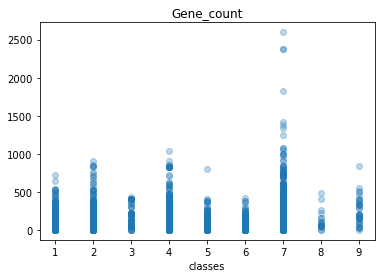

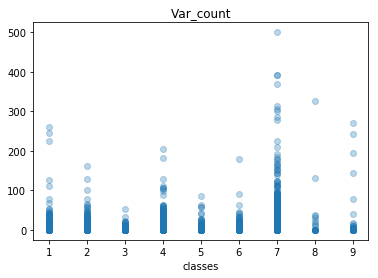

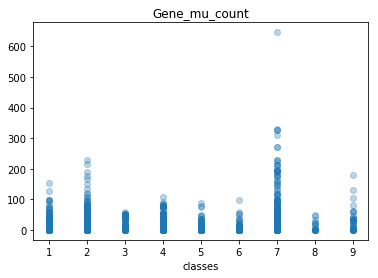

In [25]:
features = ['Gene_count', 'Var_count', 'Gene_mu_count']

for feature in features:
    plt.title(feature)
    feature = df_train2[feature]
    plt.scatter(df_train2.Class, feature, alpha=0.3)
    plt.xlabel('classes')
    plt.show()

/Users/wanggene/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


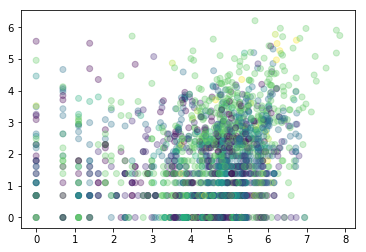

In [16]:
plt.scatter(np.log(df_train2.Gene_count), np.log(df_train2.Var_count), c = df_train.Class*3, alpha=0.3)

### Test dataset

In [4]:
#df_test2 = df_test.copy()
#df_test2['Gene_count'] = df_test.apply(gene_count, axis=1)
#df_test2['Var_count'] = df_test.apply(var_count, axis=1)
#df_test2['Gene_mu_count'] = df_test.apply(gene_count_mu, axis=1)
#df_test2['Gene_context'] = df_test.apply(gene_context, axis=1)
#df_test2['Var_context'] = df_test.apply(var_context, axis=1)
#df_test2['Cancer_context'] = df_test.apply(lambda x: word_context("cancer", df=x), axis=1)
#df_test2['Mutate_context'] = df_test.apply(lambda x: word_context("mutat", df=x), axis=1)
#df_test2.head(2)

### Merge new context columns together

In [240]:
print(df_train2.columns)
context_cols = df_train2.columns[10:] # start from 8: gene_context
df_train3 = df_train2[['ID', 'Gene', 'Variation', 'Class']]
df_train3['new_context'] = df_train2[context_cols].apply(lambda x: ''.join(x), axis=1)
df_train3.head(2)


Index(['ID', 'Gene', 'Variation', 'Class', 'Text', 'Gene_count', 'Var_count',
       'Gene_mu_count', 'Gene_context', 'Var_context', 'Cancer_context',
       'Mutate_context'],
      dtype='object')


,ID,Gene,Variation,Class,new_context
0,0,FAM58A,Truncating Mutations,1,"way, which confers tamoxifen resistance to bre..."
1,1,CBL,W802*,2,ptor molecule important in normal homeostasis ...


In [241]:
df_train3.new_context[1]

"ptor molecule important in normal homeostasis and cancer. |c-CBL mutations occur in somatic fashion for lung cancers. | it is clear that c-CBL is highly mutated in lung cancers and may play an essential role in lung tumorigenesis and metastasis. |roximately 219,400 people are diagnosed with lung cancers, out of which more than 145,000 of them succumb to the disease [1]. |hly equivalent to the combined mortality rates of cancers of the breast, prostate, colon, liver, kidney and melanoma [1]. | are also significant ethnic differences for lung cancer, and the outcome is worse for blacks compared to whites. |ber of genetic alterations that can occur in lung cancer. |he critical role of CBL in normal homeostasis and cancer, we hypothesized that it might be mutated in lung cancers. |in Caucasian, Taiwanese and African-American lung cancer patients, respectively. |o the oncogenic potential of MET and EGFR in lung cancer. |s were used for this study.  Tissue Samples  Lung cancer tissue and pa